Directory  ../fig/  already exists


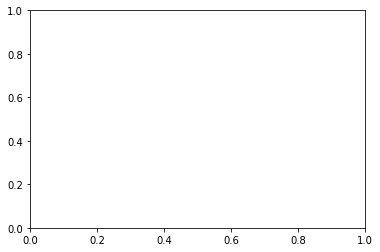

In [2]:
import logging, logging.config
logging.config.fileConfig('../config/logging.conf')
logger = logging.getLogger(__name__)

import os
import sys
from pathlib import Path
import pickle

rootdir = Path().resolve()
sys.path.insert(0, os.path.abspath(os.path.join(rootdir , '../source')))
sys.path.insert(0, os.path.abspath(os.path.join(rootdir , '../config')))

from setting import *

import data_make 
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import solver_mfreq
import multiple_solver
import plot_make 


data_make.make_dir(FIG_FOLDER)
REPLACE_OBS = False
solve_L1_TSV = False
solve_TSV = True
solve_L2 = True




#Making images
input_model, xx, yy = data_make.ring_make(XNUM, YNUM, DX, DY, RAD_RING, WIDTH_RING, function = data_make.gaussian_function_1d)

## Vertual Obervatory
obs_name = "test_observatory"
obs_file = obs_name + ".pk"
vis_file = "vis" + ".pk"


if not os.path.exists(obs_file) or REPLACE_OBS:
    obs_ex = data_make.observatory(input_model, NDATA , PERIOD, SN , OBS_DUR  , N_ANTE ,BASELINE_UVMAX, [0., 0], save_folder = FIG_FOLDER)
    obs_ex.set_antn()
    obs_ex.plotter_uv_sampling()
    vis_obs, num_mat, fft_now, noise = obs_ex.obs_make(DX, DY, SN)

    with open(obs_file, "wb") as f:
        pickle.dump(obs_ex, f)
        
    with open(vis_file, "wb") as f:
        pickle.dump((vis_obs, num_mat, fft_now, noise ), f )

else:
    
    with open(obs_file, "rb") as f:
        obs_ex = pickle.load(f) 
        
    with open(vis_file, "rb") as f:
        vis_obs, num_mat, fft_now, noise = pickle.load(f) 
        

## Making obs data
#
#vis_test = vis_obs

## Images from obs
vis_obs_shift = np.fft.ifftshift(vis_obs)
beam_func = np.zeros(np.shape(num_mat))
beam_func[num_mat>0] = 1
beam_func = np.fft.fftshift(beam_func)
dirty_image = np.fft.ifft2(vis_obs)
beam_image = np.fft.fftshift(np.fft.ifft2(beam_func))
plot_make.image_2dplot(vis_obs_shift,  lim = 127)
plot_make.image_2dplot(np.abs(beam_image),  lim = 127)


## Setting priors for model
model_prior = np.zeros(np.shape(dirty_image))
images = model_prior


## L1 & TSV regluarzation + positive condition
l2_lambda = 10**-2
l1_lambda = 10**-1
eta_init = 1.3
positive_solve =True

if solve_L1_TSV:
    model_map3, solved_flag3 = solver_mfreq.fx_L1_mfista(images, solver_mfreq.loss_function_arr_TSV, \
        solver_mfreq.grad_loss_tsv, solver_mfreq.L1_norm, ETA_INIT, L_INIT, 300, 299, positive_solve ,\
         STOP_RATIO,RESTART, vis_obs, noise, l1_lambda, l2_lambda)


l2_lambda = 10**0
#"""
if solve_TSV:
    model_map2, solved_flag2 = solver_mfreq.only_fx_mfista(images, solver_mfreq.loss_function_arr_TSV, \
        solver_mfreq.grad_loss_tsv, solver_mfreq.zero_func, ETA_INIT, L_INIT, 300, 299, positive_solve ,\
         STOP_RATIO, RESTART, vis_obs, noise, model_prior, l2_lambda)
#"""

#"""
if solve_L2:
    model_map_l2, solved_flag_l2 = solver_mfreq.only_fx_mfista(images, solver_mfreq.loss_function_arr_l2, \
        solver_mfreq.grad_loss_l2, solver_mfreq.zero_func, ETA_INIT, L_INIT, 300, 299, positive_solve ,\
         STOP_RATIO, RESTART, vis_obs, noise, model_prior, l2_lambda)
#"""




In [2]:
 def flux_sum(arrs, width):
    n_arr, nx, ny = np.shape(arrs)
    cen = int(nx/2)
    sum_arr = []
    for i in range(n_arr):
        sum_arr.append(np.sum(arrs[i][cen-width:cen+width,cen-width:cen+width]))
    return np.array(sum_arr)

x_len, y_len = np.shape(input_model)
width_im = 40

plt.imshow(model_map3)
plt.xlim(int(x_len/2) - width_im,int(x_len/2) + width_im)
plt.ylim(int(x_len/2) - width_im,int(x_len/2) + width_im)
plt.colorbar()
plt.show()


plt.imshow(model_map_l2)
plt.xlim(int(x_len/2) - width_im,int(x_len/2) + width_im)
plt.ylim(int(x_len/2) - width_im,int(x_len/2) + width_im)
plt.colorbar()
plt.show()

plt.imshow(model_map2)
plt.xlim(int(x_len/2) - width_im,int(x_len/2) + width_im)
plt.ylim(int(x_len/2) - width_im,int(x_len/2) + width_im)
plt.colorbar()
plt.show()


plt.imshow(input_model)
plt.xlim(int(x_len/2) - width_im,int(x_len/2) + width_im)
plt.ylim(int(x_len/2) - width_im,int(x_len/2) + width_im)
plt.colorbar()
plt.show()


plt.imshow( model_map3 - input_model )
plt.colorbar()
plt.show()
print(np.sum(model_map3), np.sum(input_model), np.sum(model_map2))

width =20

result = flux_sum([input_model, model_map3, model_map2], width)
print(result)



NameError: name 'model_map3' is not defined

In [ ]:
plt.imshow(vis_obs.real)
plt.colorbar()
plt.show()

plt.imshow(fft_now.real)
plt.colorbar()
plt.show()


plt.imshow(fft_now.imag)
plt.colorbar()
plt.show()

plt.imshow(np.abs(fft_now))
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(np.fft.fftshift(input_model))

In [ ]:
#np.arange(0,4,1)